In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import os
import time
import numpy as np
import cv2 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
directory = '../../data/PetImages'

In [3]:
def get_images(dir_path, resize: tuple|None = None, to_save: bool|None = None, limit: int|None=None):
    names = sorted(os.listdir(dir_path))
    images = []
    
    for name in names:
        if not name.endswith('.jpg'):
            continue
        
        path = os.path.join(dir_path, name)
        path = os.path.abspath(path)
        img = cv2.imread(os.path.abspath(path))
        if img is None:
            print('Found broken(4 cv2) or empty image:', path)
            continue
        
        
        if resize is not None:
            img = cv2.resize(img, resize)
            
        if to_save is not None and to_save:
            category = os.path.basename(os.path.normpath(dir_path))
            out_dir = os.path.join(directory, "New", category)
            os.makedirs(out_dir, exist_ok=True)
            out_path = os.path.join(out_dir, name)
            cv2.imwrite(out_path, img)

        images.append(img)
        
        if limit is not None and len(images) == limit:
            break
        
    return images

In [4]:
os.system(f'rm -r {directory}/New')
time.sleep(1)

N = 300
resize=128

images = \
get_images(f'{directory}/Cat', limit=N, to_save=True, resize=(resize,resize)) + \
get_images(f'{directory}/Dog',limit=N, to_save=True, resize=(resize,resize))

labels = [0] * N + [1] * N

Found broken(4 cv2) or empty image: /Users/maus/Documents/VSCode/spbu-ml-2025/data/PetImages/Cat/10125.jpg
Found broken(4 cv2) or empty image: /Users/maus/Documents/VSCode/spbu-ml-2025/data/PetImages/Dog/10158.jpg


In [5]:
def plot_images(images, labels, n, m):
    fig, axes = plt.subplots(n, m, figsize=(5*m, 5*n))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(labels[i], fontsize=24)
        ax.axis('off')

    plt.show()

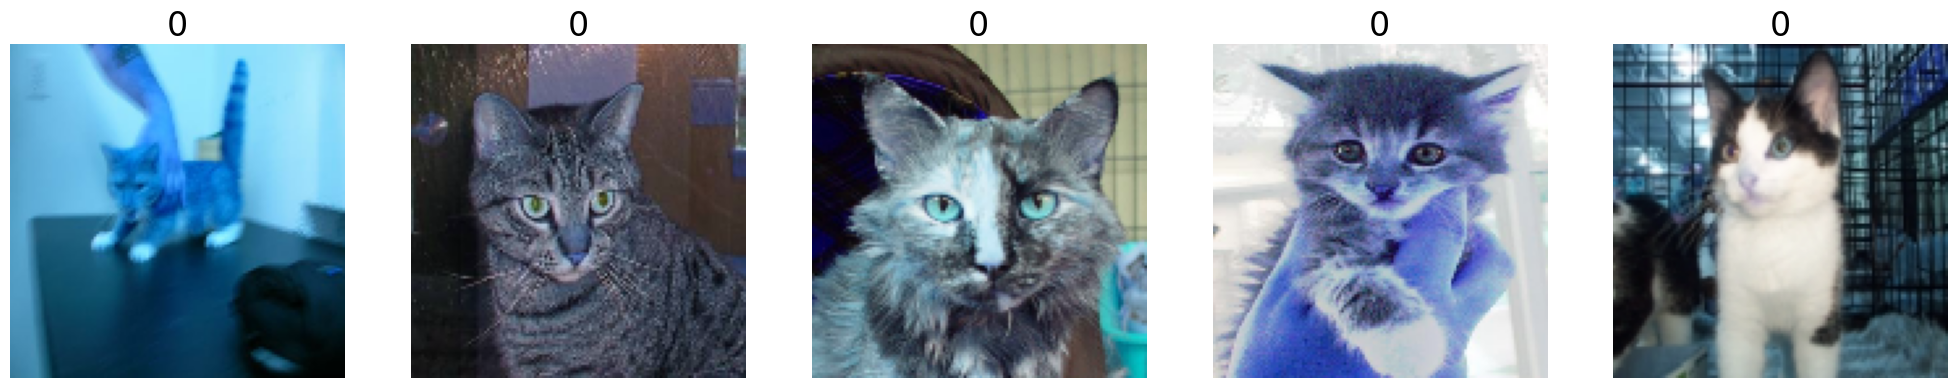

In [6]:
plot_images(images[0:5], labels[0:5], 1, 5)

In [7]:
images, labels = np.array(images), np.array(labels)

X = images.reshape((images.shape[0], -1))
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print('train shape:', X_train.shape)
print('test images shape:', X_test.shape)

train shape: (480, 49152)
test images shape: (120, 49152)


In [8]:
model_lr = LogisticRegression(max_iter=1000)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, y_pred_rf)

print("LR accuracy:", acc_lr)
print("RF accuracy:", acc_rf)

LR accuracy: 0.5333333333333333
RF accuracy: 0.6416666666666667


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = 50
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [10]:
model_lr_pca = LogisticRegression(max_iter=1000)
model_rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
model_lr_pca.fit(X_train_pca, y_train)
model_rf_pca.fit(X_train_pca, y_train)
y_pred_lr_pca = model_lr_pca.predict(X_test_pca)
y_pred_rf_pca = model_rf_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred_lr_pca))
print()
print(classification_report(y_test, y_pred_rf_pca))

              precision    recall  f1-score   support

           0       0.60      0.77      0.67        60
           1       0.67      0.48      0.56        60

    accuracy                           0.62       120
   macro avg       0.64      0.62      0.62       120
weighted avg       0.64      0.62      0.62       120


              precision    recall  f1-score   support

           0       0.61      0.77      0.68        60
           1       0.69      0.52      0.59        60

    accuracy                           0.64       120
   macro avg       0.65      0.64      0.64       120
weighted avg       0.65      0.64      0.64       120



100%|██████████| 39/39 [04:59<00:00,  7.69s/it]


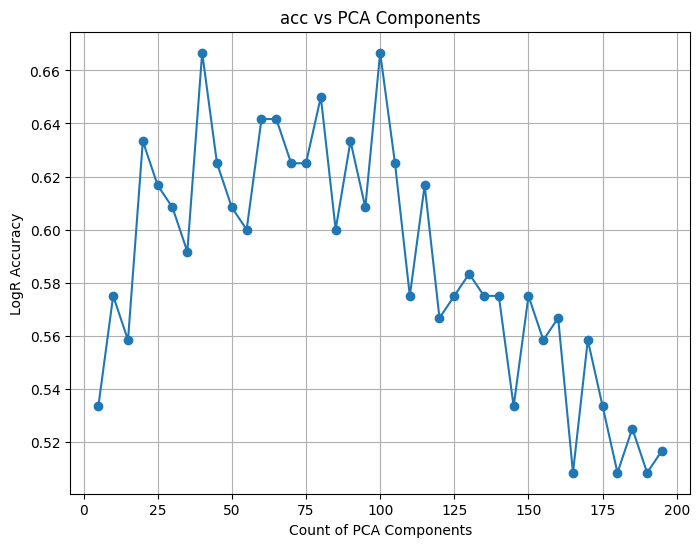

In [11]:
import tqdm

components_l = range(5, 200, 5)
accs = []
for comp in tqdm.tqdm(components_l):
    pca = PCA(n_components=comp, whiten=True)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model_lr_pca = LogisticRegression(max_iter=1000)
    model_lr.fit(X_train_pca, y_train)
    acc = accuracy_score(y_test, model_lr.predict(X_test_pca))
    accs.append(acc)
    
plt.figure(figsize=(8,6))
plt.plot(components_l, accs, marker='o')
plt.xlabel('Count of PCA Components')
plt.ylabel('LogR Accuracy')
plt.title('acc vs PCA Components')
plt.grid(True)
plt.show()

In [11]:
# вычисляем кумулятивную сумму долей дисперсии, объясняемых компонентами
# и далее находим мин число компонент, при котором эта сумма >= 90%
pca_full = PCA().fit(X_train_scaled)
cum_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_comp_90 = np.searchsorted(cum_variance, 0.90) + 1
print(f'components - 90% variance: {n_comp_90}')


components - 90% variance: 142


(ДЛЯ logisticReg)При 142 компонентах accuracy = .6, что ниже, чем при 75 компонентах 

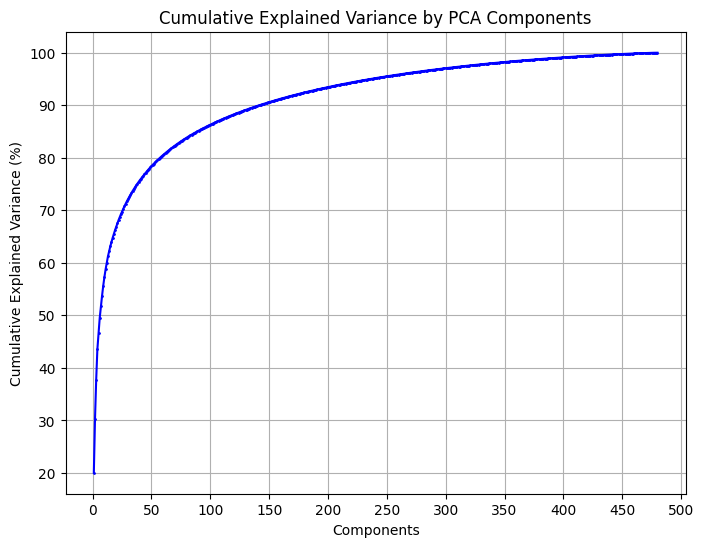

In [12]:
pca_full = PCA().fit(X_train_scaled)

cum_variance = np.cumsum(pca_full.explained_variance_ratio_) * 100
comps = np.arange(1, len(cum_variance) + 1)

plt.figure(figsize=(8, 6))
plt.plot(comps, cum_variance, marker='o', color='blue', markersize=1)
plt.xlabel("Components")
plt.ylabel('Cumulative Explained Variance (%)')
plt.title("Cumulative Explained Variance by PCA Components")
plt.grid(True)
plt.locator_params(axis='x', nbins=20)
plt.show()



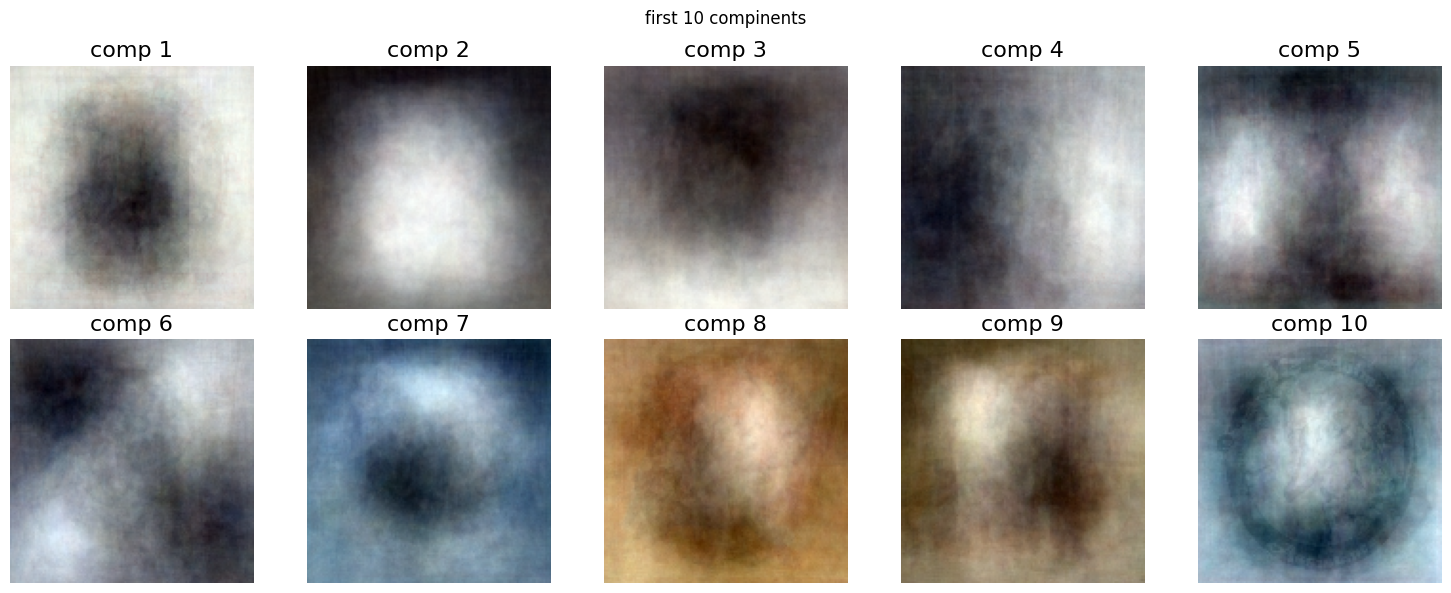

In [13]:
n_comp = 75
pca_best = PCA(n_components=n_comp, whiten=True, random_state=42)
X_train_pca_best = pca_best.fit_transform(X_train_scaled)

n = min(10, pca_best.components_.shape[0])

plt.figure(figsize=(15, 6))
for i in range(n):
    comp = pca_best.components_[i]
    chans = comp.shape[0] // (resize ** 2)
    comp_img = comp.reshape((resize, resize, chans))
    
    comp_min, comp_max = comp_img.min(), comp_img.max()
    
    comp_img_norm = (comp_img - comp_min) / (comp_max - comp_min + 1e-8)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp_img_norm)
    plt.axis('off')
    plt.title(f'comp {i + 1}', fontsize=16)
    plt.axis('off')
    
plt.suptitle("first 10 compinents")
plt.tight_layout()
plt.show()
    

In [15]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tqdm

models = {
    'LogR': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'KN': KNeighborsClassifier(n_neighbors=5),
    'DTree': DecisionTreeClassifier(random_state=42),
    # 'GBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVC': SVC(random_state=42),
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results_metrics_original = {}
for name, model in tqdm.tqdm(models.items(), desc='[original]Training'):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    m = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    }
    results_metrics_original[name] = m
    
print('Original accuracy')
for name, acc in results_metrics_original.items():
    print(name, acc)

[original]Training: 100%|██████████| 5/5 [00:23<00:00,  4.61s/it]

Original accuracy
LogR {'accuracy': 0.5583333333333333, 'f1': 0.5545906576090762}
RF {'accuracy': 0.6416666666666667, 'f1': 0.6414425682718365}
KN {'accuracy': 0.475, 'f1': 0.4666666666666667}
DTree {'accuracy': 0.5333333333333333, 'f1': 0.53125}
SVC {'accuracy': 0.6583333333333333, 'f1': 0.658309604833669}


In [ ]:
def best_count_pca_components_for_model(model, X_train, y_train, X_test, y_test):
    components_l = range(15, 151, 10)
    accs = []
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    for comp in tqdm.tqdm(components_l, desc=f'finding best count of components'):
        pca = PCA(n_components=comp, whiten=True)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        model.fit(X_train_pca, y_train)
        acc = accuracy_score(y_test, model.predict(X_test_pca))
        accs.append(acc)

    best_count = components_l[np.argmax(accs)]
    return best_count

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results_metrics_pca = {}

for name, model in models.items():
    n_comp = best_count_pca_components_for_model(model, X_train, y_train, X_test, y_test)
    print(n_comp)
    pca = PCA(n_components=n_comp, whiten=True)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    
print('PCA accuracy')
for name, acc in results_metrics_pca.items():
    print(name, acc)

finding best count of components: 100%|██████████| 14/14 [01:39<00:00,  7.09s/it]


75


finding best count of components: 100%|██████████| 14/14 [01:46<00:00,  7.57s/it]


25


finding best count of components: 100%|██████████| 14/14 [01:39<00:00,  7.08s/it]


125


finding best count of components: 100%|██████████| 14/14 [01:44<00:00,  7.44s/it]


25


finding best count of components: 100%|██████████| 14/14 [01:40<00:00,  7.18s/it]


25
PCA accuracy
LogR {'accuracy': 0.6416666666666667, 'f1': 0.6410434782608696}
RF {'accuracy': 0.5916666666666667, 'f1': 0.5882064570348063}
KN {'accuracy': 0.5083333333333333, 'f1': 0.4731750874321006}
DTree {'accuracy': 0.5833333333333334, 'f1': 0.5791245791245793}
SVC {'accuracy': 0.6166666666666667, 'f1': 0.613986013986014}


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results_metrics_pca = {}

n_comp = {
    'LogR': 75,
    'RF': 25,
    'KN': 125,
    'DTree': 25,
    # 'GBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVC': 25,
}

for name, model in tqdm.tqdm(models.items()):
    
    pca = PCA(n_components=n_comp[name], whiten=True)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    
    m = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    }
    results_metrics_pca[name] = m
print('PCA accuracy')
for name, acc in results_metrics_pca.items():
    print(name, acc)

 60%|██████    | 3/5 [00:40<00:27, 13.60s/it]


KeyboardInterrupt: 

In [41]:
results_metrics_original, results_metrics_pca

({'LogR': {'accuracy': 0.5583333333333333, 'f1': 0.5545906576090762},
  'RF': {'accuracy': 0.6416666666666667, 'f1': 0.6414425682718365},
  'KN': {'accuracy': 0.475, 'f1': 0.4666666666666667},
  'DTree': {'accuracy': 0.5333333333333333, 'f1': 0.53125},
  'SVC': {'accuracy': 0.6583333333333333, 'f1': 0.658309604833669}},
 {'LogR': {'accuracy': 0.6416666666666667, 'f1': 0.6410434782608696},
  'RF': {'accuracy': 0.6416666666666667, 'f1': 0.6303460133247367},
  'KN': {'accuracy': 0.575, 'f1': 0.5402298850574713},
  'DTree': {'accuracy': 0.49166666666666664, 'f1': 0.48562996275736064},
  'SVC': {'accuracy': 0.625, 'f1': 0.6218222564605365}})

- logR выиграл от устранения

In [20]:
cats = get_images(f'{directory}/Cat', limit=300, resize=(resize,resize))
dogs = get_images(f'{directory}/Dog', limit=300, resize=(resize,resize))

cats = np.array(cats)
dogs = np.array(dogs)

cats_flat = cats.reshape(cats.shape[0], -1)
dogs_flat = dogs.reshape(dogs.shape[0], -1)

correlation = np.corrcoef(cats_flat.ravel(), dogs_flat.ravel())[0, 1]
print("Correlation between cats and dogs:", correlation)


Found broken(4 cv2) or empty image: /Users/maus/Documents/VSCode/spbu-ml-2025/data/PetImages/Cat/10125.jpg
Found broken(4 cv2) or empty image: /Users/maus/Documents/VSCode/spbu-ml-2025/data/PetImages/Dog/10158.jpg
Correlation between cats and dogs: 0.01972539219805042


In [ ]:
pca = PCA(n_components=75,whiten=True)
X_train_pca = pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)
df_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

(480, 75)
